In [1]:
import os
import numpy as np

import torch
M1 = False

if M1:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="1"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(torch.cuda.is_available())
        print(torch.cuda.device_count())
        print(torch.cuda.current_device())
        print(torch.cuda.get_device_name(torch.cuda.current_device()))


from functools import partial
import math
import time as time
from tqdm import tqdm

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchmetrics.functional import structural_similarity_index_measure 
from torchmetrics.functional import peak_signal_noise_ratio 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
sns.set(font_scale=1.5)
# plt.style.use('dark_background')
plt.rcParams["font.family"] = "serif"

import scipy.io as sio
from astropy.io import fits

import large_scale_UQ as luq
from large_scale_UQ.utils import to_numpy, to_tensor
from convex_reg import utils as utils_cvx_reg



True
1
0
NVIDIA A100-PCIE-40GB
Using device: cuda


In [2]:
# Optimisation parameters
options = {"tol": 1e-5, "iter": 5000, "update_iter": 4999, "record_iters": False}

# Wavelet parameters
wavs_list = ['db8'] # ["db1", "db4"] 
levels = 4
reg_param = 2.e-3



In [3]:
# Save param
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
# repo_dir = '/Users/tl/Documents/research/repos/proj-convex-UQ/large-scale-UQ'
save_dir = repo_dir + '/debug/sampling-outputs/'
# %%
img_name = 'M31'

# Load img
img_path = '/disk/xray0/tl3/repos/large-scale-UQ/data/imgs/{:s}.fits'.format(img_name)
img_data = fits.open(img_path, memmap=False)

# Loading the image and cast it to float
img = np.copy(img_data[0].data)[0,:,:].astype(np.float64)
# Flipping data
img = np.flipud(img)

# Aliases
x = img
ground_truth = img

#
myType = torch.float64
myComplexType = torch.complex128

# %%
# Load op from X Cai
mask_path = repo_dir + '/data/operators_masks/fourier_mask.mat'
op_mask = sio.loadmat(mask_path)['Ma']

# Matlab's reshape works with 'F'-like ordering
mat_mask = np.reshape(np.sum(op_mask, axis=0), (256,256), order='F').astype(bool)

# %%

torch_img = torch.tensor(np.copy(img), dtype=myType, device=device).reshape((1,1) + img.shape)

# %%
dim = 256
phi = luq.operators.MaskedFourier_torch(
    dim=dim, 
    ratio=0.5 ,
    mask=mat_mask,
    norm='ortho',
    device=device
)


# Define X Cai noise level
sigma = 0.0024

y = phi.dir_op(torch_img).detach().cpu().squeeze().numpy()

# Generate noise
rng = np.random.default_rng(seed=0)
n = rng.normal(0, sigma, y[y!=0].shape)
# Add noise
y[y!=0] += n

# Observation
torch_y = torch.tensor(np.copy(y), device=device, dtype=myComplexType).reshape((1,) + img.shape)
x_init = torch.abs(phi.adj_op(torch_y))

# %%

# Define the likelihood
g = luq.operators.L2Norm_torch(
    sigma=sigma,
    data=torch_y,
    Phi=phi,
)
g.beta = 1.0 / sigma ** 2


# Define the wavelet dict
# Define the l1 norm with dict psi
# gamma = torch.max(torch.abs(psi.dir_op(y_torch))) * reg_param
psi = luq.operators.DictionaryWv_torch(wavs_list, levels)

h = luq.operators.L1Norm_torch(1., psi, op_to_coeffs=True)
gamma = h._get_max_abs_coeffs(h.dir_op(torch.clone(x_init))) * reg_param
h.gamma = gamma
h.beta = 1.0

print('gamma: ', gamma)

f = luq.operators.RealProx_torch()



INSTRUME                                                                         [astropy.io.fits.card]


gamma:  0.0073399448136145734


In [4]:
alpha = 1. / (1. + g.beta)

x_hat, diagnostics = luq.optim.FB_torch(
    x_init,
    options=options,
    g=g,
    f=f,
    h=h,
    alpha=alpha,
    tau=1.,
    viewer=None
)


Running Base Forward Backward
[Forward Backward] 0 out of 5000 iterations, tol = 4.08e-01
[Forward Backward] converged in 95 iterations


In [5]:

x_hat_np = luq.utils.to_numpy(x_hat)


Dirty
(PSNR: 27.45,
 SNR: 5.01, SSIM: 0.35)
Reconstruction
(PSNR: 45.82,
 SNR: 23.38, SSIM: 0.98)
Residual (x - x^hat)
(PSNR: 22.56,
 SNR: 0.12, SSIM: 0.77)


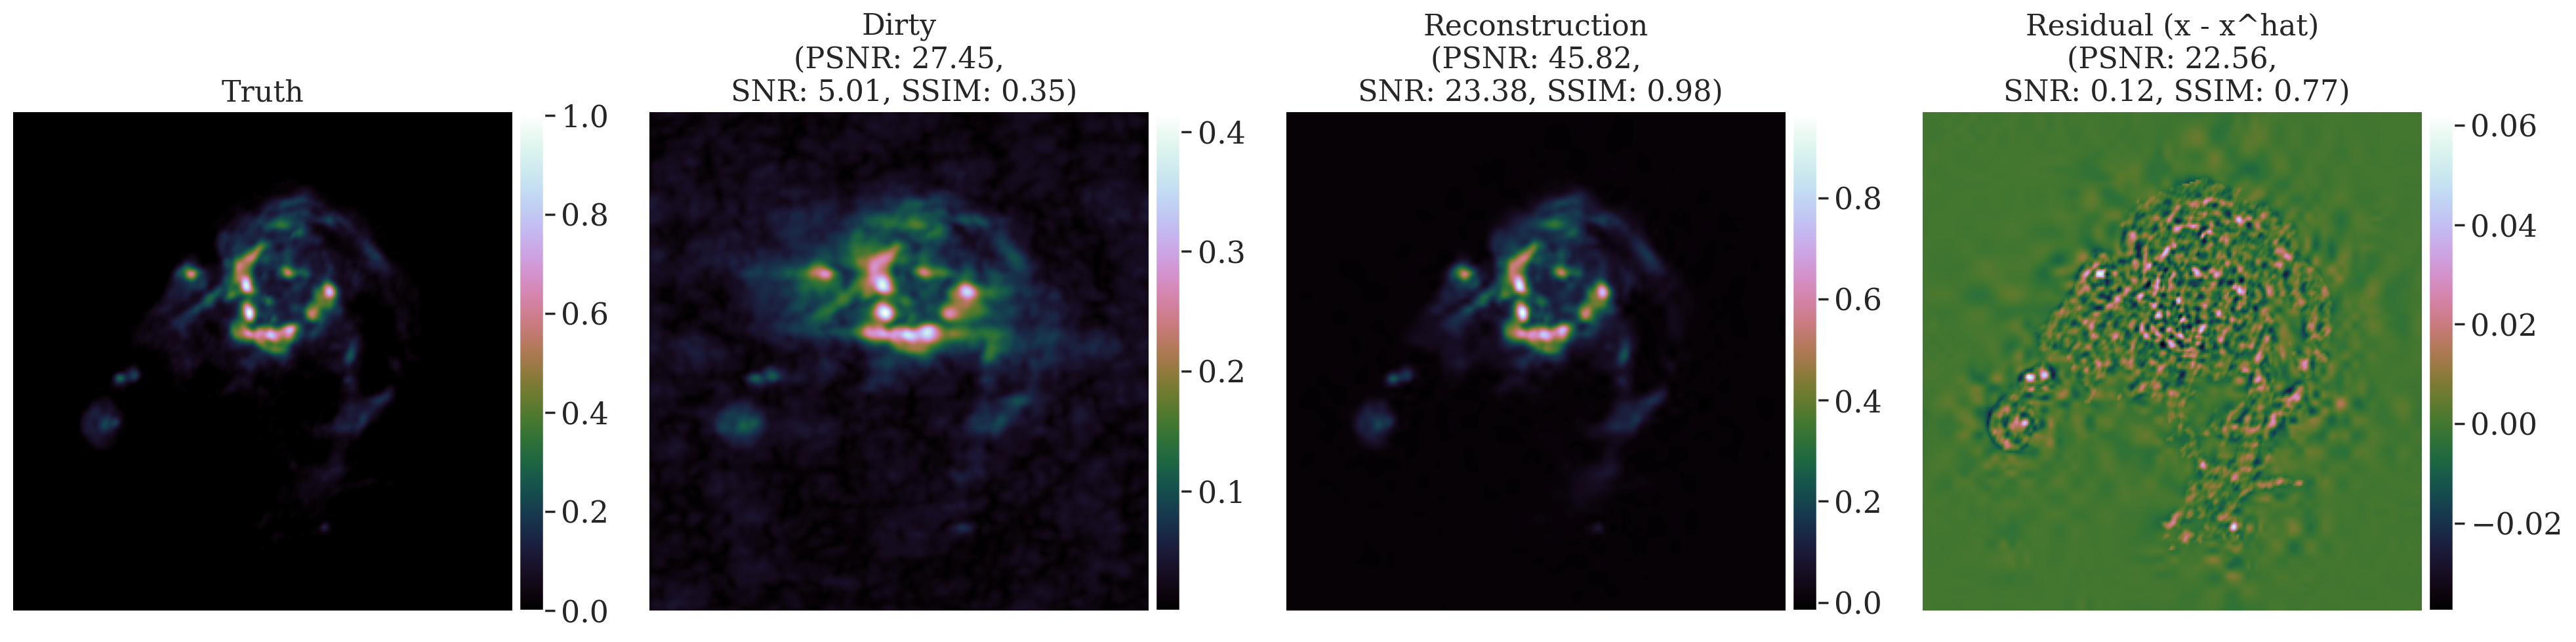

In [6]:
cmap='cubehelix'

# Plot results
images = [
    ground_truth,
    luq.utils.to_numpy(x_init),
    x_hat_np,
    ground_truth - x_hat_np
]
labels = ["Truth", "Dirty", "Reconstruction", "Residual (x - x^hat)"]

fig, axs = plt.subplots(1,4, figsize=(24,6), dpi=200)
for i in range(4):
    im = axs[i].imshow(images[i], cmap='cubehelix', vmax=np.nanmax(images[i]), vmin=np.nanmin(images[i]))
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    if i > 0:   
        stats_str = '\n(PSNR: {},\n SNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
            round(luq.utils.eval_snr(x, images[i]), 2),
            round(ssim(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
            )
        labels[i] += stats_str
        print(labels[i])
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')
# plt.savefig('{:s}{:s}_MAP.pdf'.format(savefig_dir, save_name))
# plt.close()
plt.show()


In [7]:



# Sampling alg params
frac_burnin = 0.2
n_samples = np.int64(1e2)
thinning = np.int64(1e2)
maxit = np.int64(n_samples * thinning * (1. + frac_burnin))

frac_delta = 0.1



In [8]:
# Define likelihood functions
fun_likelihood = lambda _x : g.fun(_x)
grad_likelihood = lambda _x : g.grad(_x)
L_likelihood = g.beta

# Define prior
lambda_prox = 1. / L_likelihood
lambd_frac = 0.99
lambd = lambda_prox * lambd_frac

fun_prior = lambda _x : h._fun_coeffs(h.dir_op(_x))

prox_prior = lambda _x: h.adj_op(h.prox(h.dir_op(torch.clone(_x)), lambd))
grad_prior = lambda _x: (_x - prox_prior(_x)) / lambd 

# Define posterior and gradient
logPi = lambda _z :  fun_likelihood(_z) + fun_prior(_z)
grad_likelihood_prior = lambda _x : torch.real(grad_likelihood(_x) + grad_prior(_x))


In [9]:

# Define kernel
def ULA_kernel(X, delta):
    return X - delta * grad_likelihood_prior(X) + math.sqrt(2*delta) * torch.randn_like(X)



In [10]:
L_prior = 1 / lambd
L = L_likelihood + L_prior
delta = 1. * frac_delta / L

print('delta', delta)


delta 2.8655276381909547e-07


In [11]:
# Sampling alg params
burnin = np.int64(n_samples * thinning * frac_burnin)
X = x_init.clone()
MC_X = np.zeros((n_samples, X.shape[1], X.shape[2]))
logpi_thinning_trace = np.zeros((n_samples-1, 1))
thinned_trace_counter = 0
# thinning_step = np.int64(maxit/n_samples)

psnr_values = []
ssim_values = []
logpi_eval = []

# %%
start_time = time.time()
for i_x in tqdm(range(maxit)):

    # Update X
    X = luq.sampling.ULA_kernel(X, delta, grad_likelihood_prior)
    # X = MYULA_kernel(X, gamma)

    if i_x == burnin:
        # Initialise recording of sample summary statistics after burnin period
        post_meanvar = luq.utils.welford(X)
        absfouriercoeff = luq.utils.welford(torch.fft.fft2(X).abs())
    elif i_x > burnin:
        # update the sample summary statistics
        post_meanvar.update(X)
        absfouriercoeff.update(torch.fft.fft2(X).abs())

        # collect quality measurements
        current_mean = post_meanvar.get_mean()
        psnr_values.append(peak_signal_noise_ratio(current_mean, torch_img).item())
        ssim_values.append(structural_similarity_index_measure(current_mean, torch_img).item())
        logpi_eval.append(logPi(X).item())

        # collect thinned trace
        if np.mod(i_x - burnin, thinning) == 0:
            MC_X[thinned_trace_counter] = X.detach().cpu().numpy()
            logpi_thinning_trace[thinned_trace_counter] = logPi(X).item()
            thinned_trace_counter += 1

end_time = time.time()
elapsed = end_time - start_time    

current_mean = post_meanvar.get_mean()
current_var = post_meanvar.get_var().detach().cpu().squeeze()



100%|██████████| 12000/12000 [01:39<00:00, 121.01it/s]


In [12]:

X

tensor([[[[-0.1556, -0.1051,  0.1013,  ..., -0.1043, -0.0093, -0.1065],
          [-0.0273,  0.1016,  0.0360,  ...,  0.0402, -0.0602,  0.0586],
          [-0.0223,  0.0701, -0.1257,  ...,  0.0285, -0.0888, -0.0244],
          ...,
          [-0.0567, -0.0338,  0.0358,  ..., -0.0379,  0.0518,  0.0490],
          [-0.0791,  0.0465, -0.0029,  ..., -0.0004, -0.0606,  0.0874],
          [ 0.0296,  0.0134, -0.0575,  ..., -0.0817,  0.0696, -0.0875]]]],
       device='cuda:0', dtype=torch.float64)

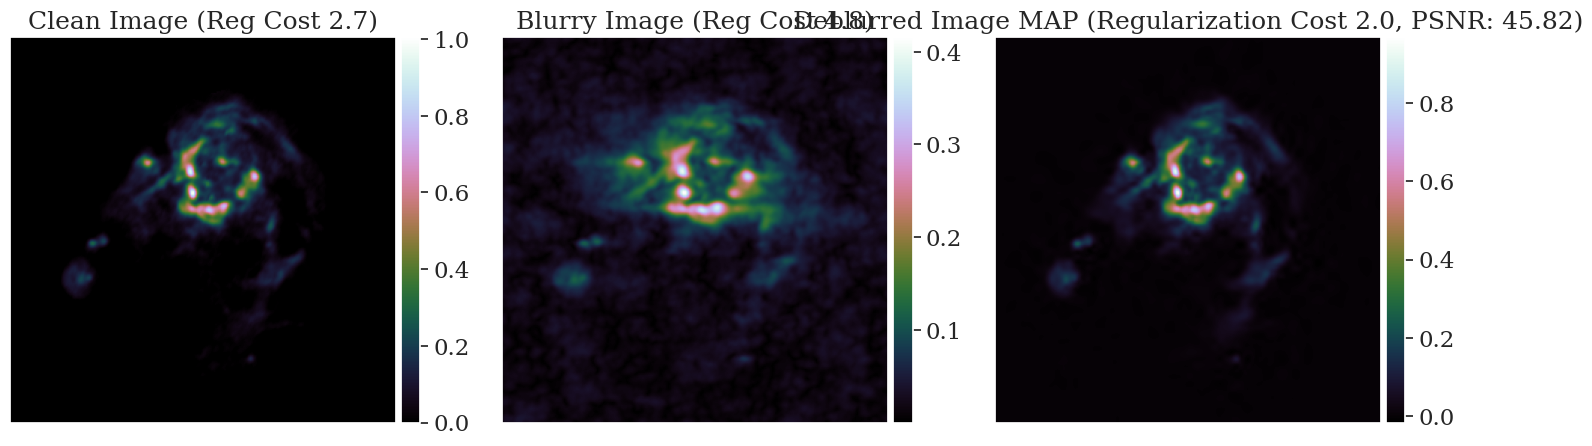

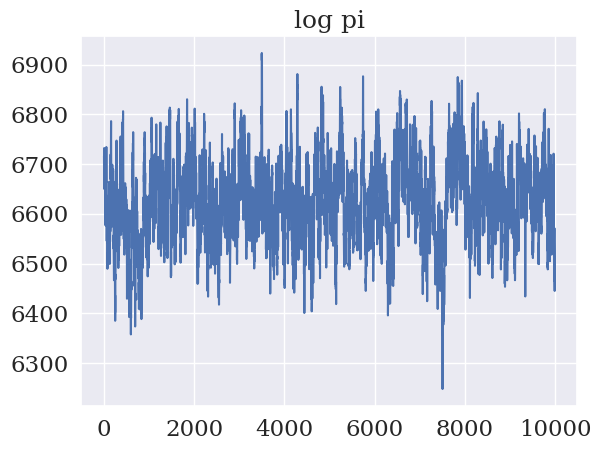

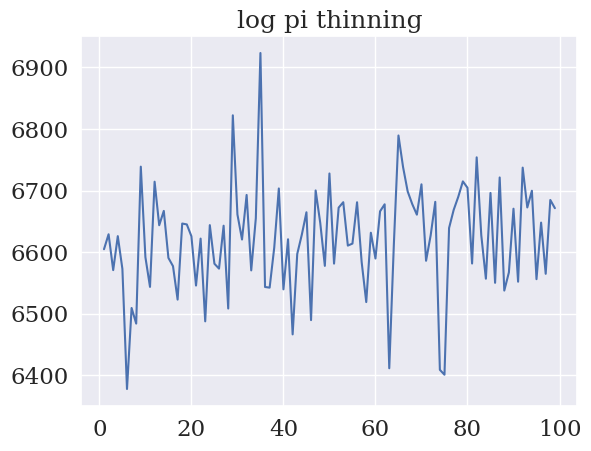

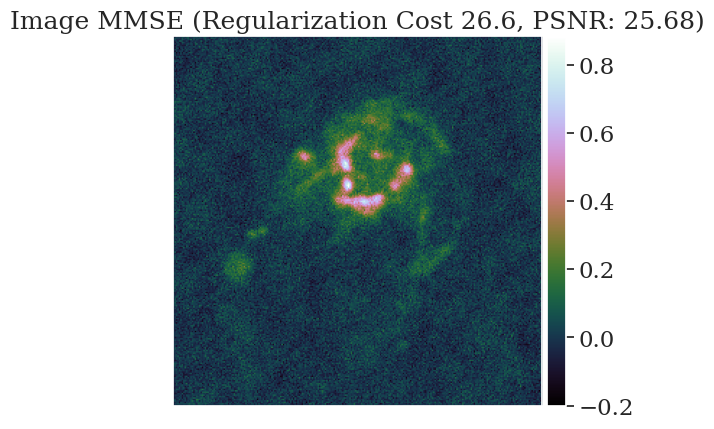

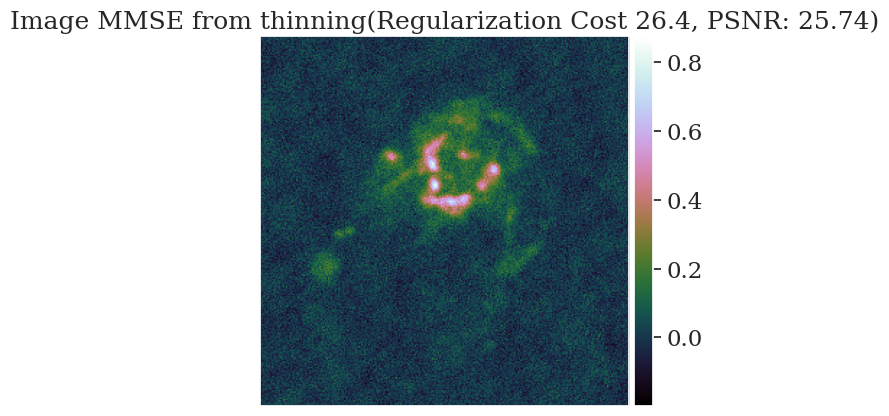

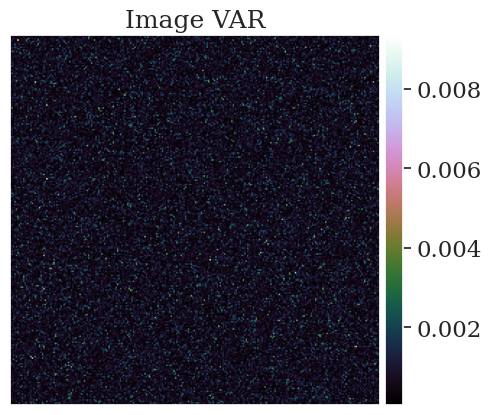

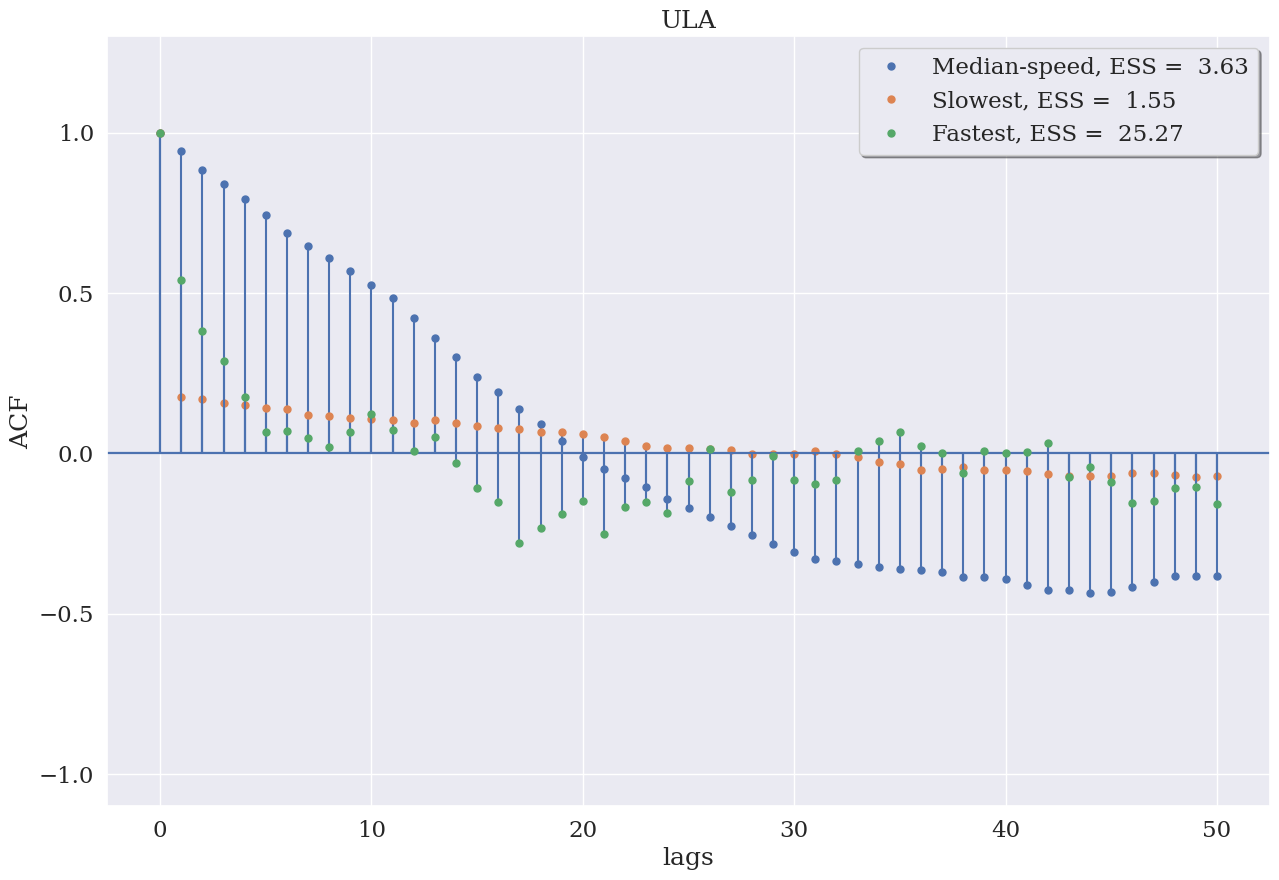

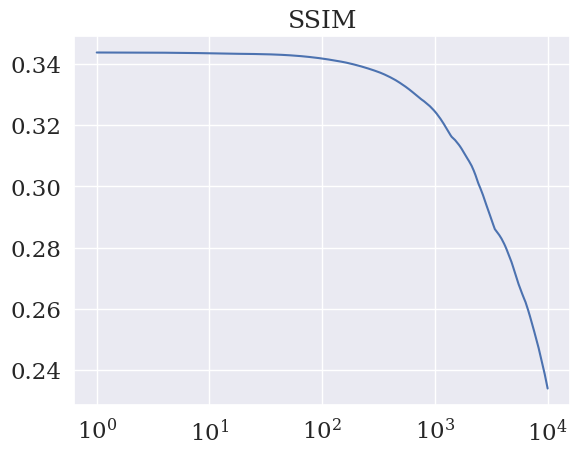

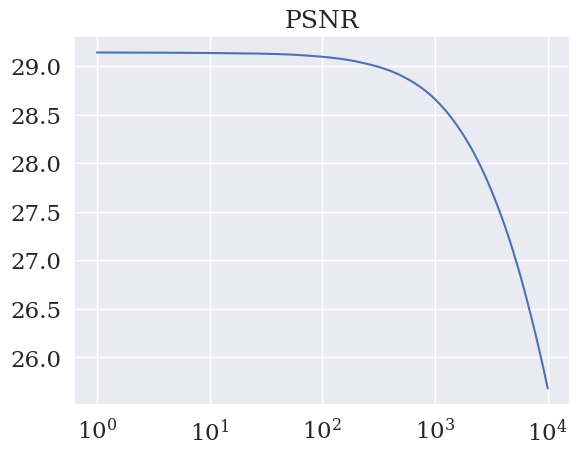

In [13]:


cmap='cubehelix'

savefig_dir = save_dir + 'figs/'

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
ax[0].set_title(f"Clean Image (Reg Cost {fun_prior(torch_img):.1f})")
im = ax[0].imshow(torch_img.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[0].set_yticks([]);ax[0].set_xticks([])

ax[1].set_title(f"Blurry Image (Reg Cost {fun_prior(x_init):.1f})")
im = ax[1].imshow(x_init.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[1].set_yticks([]);ax[1].set_xticks([])

ax[2].set_title(f"Deblurred Image MAP (Regularization Cost {fun_prior(x_hat):.1f}, PSNR: {peak_signal_noise_ratio(x_hat, torch_img).item():.2f})")
im = ax[2].imshow(x_hat.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax[2].set_yticks([]);ax[2].set_xticks([])
# plt.savefig(savefig_dir+save_prefix+'_MAP_optim.pdf')
plt.show()
# plt.close()


fig, ax = plt.subplots()
ax.set_title("log pi")
ax.plot(np.arange(1,len(logpi_eval)+1), logpi_eval)
# plt.savefig(savefig_dir+save_prefix+'_log_pi_sampling.pdf')
plt.show()
# plt.close()

fig, ax = plt.subplots()
ax.set_title("log pi thinning")
ax.plot(np.arange(1,len(logpi_thinning_trace)+1), logpi_thinning_trace)
# plt.savefig(savefig_dir+save_prefix+'_log_pi_thinning_sampling.pdf')
plt.show()
# plt.close()

fig, ax = plt.subplots()
ax.set_title(f"Image MMSE (Regularization Cost {fun_prior(current_mean):.1f}, PSNR: {peak_signal_noise_ratio(current_mean, torch_img).item():.2f})")
im = ax.imshow(current_mean.detach().cpu().squeeze(), cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])
# plt.savefig(savefig_dir+save_prefix+'_MMSE_sampling.pdf')
plt.show()
# plt.close()


MC_X_mean = np.mean(MC_X, axis=0)

fig, ax = plt.subplots()
ax.set_title(f"Image MMSE from thinning(Regularization Cost {fun_prior(to_tensor(MC_X_mean, device=device)):.1f}, PSNR: {peak_signal_noise_ratio(to_tensor(MC_X_mean, device=device), torch_img).item():.2f})")
im = ax.imshow(MC_X_mean, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([])
ax.set_xticks([])
# plt.savefig(savefig_dir+save_prefix+'_MMSE_thinning_sampling.pdf')
plt.show()
# plt.close()

fig, ax = plt.subplots()
ax.set_title(f"Image VAR")
im = ax.imshow(current_var, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_yticks([]);ax.set_xticks([])
# plt.savefig(savefig_dir+save_prefix+'_variance_sampling.pdf')
plt.show()
# plt.close()

luq.utils.autocor_plots(
    MC_X,
    current_var,
    "ULA",
    nLags=50,
    # save_path=savefig_dir+save_prefix+'_autocorr_plot.pdf'
)

fig, ax = plt.subplots()
ax.set_title("SSIM")
ax.semilogx(np.arange(1,len(ssim_values)+1), ssim_values)
# plt.savefig(savefig_dir+save_prefix+'_SSIM_evolution.pdf')
plt.show()
# plt.close()

fig, ax = plt.subplots()
ax.set_title("PSNR")
ax.semilogx(np.arange(1,len(psnr_values)+1), psnr_values)
# plt.savefig(savefig_dir+save_prefix+'_PSNR_evolution.pdf')
plt.show()
# plt.close()


